## Download the training data from google drive
https://drive.google.com/file/d/1EQSfJx553yGczcQlYckqw8OfA5ODys0M/view?usp=sharing

In [1]:
import torch
print(torch.cuda.get_device_name()) 

Tesla T4


In [2]:
!gdown --id '1EQSfJx553yGczcQlYckqw8OfA5ODys0M' --output pineapple.zip
!unzip -q pineapple.zip

/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1EQSfJx553yGczcQlYckqw8OfA5ODys0M
To: /content/pineapple.zip
100% 20.1M/20.1M [00:01<00:00, 18.2MB/s]


## Import library

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
# "ConcatDataset" and "Subset" are possibly useful when doing semi-supervised learning.
from torch.utils.data import ConcatDataset, DataLoader, Subset, Dataset
from torchvision.datasets import DatasetFolder, ImageFolder
import torchvision.models as models

import matplotlib.pyplot as plt
# This is for the progress bar.
from tqdm.auto import tqdm

## Dataset, Dataloader, Transforms

In [4]:
train_tfm = transforms.Compose([
    # TODO: Add data augmentation for training data
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=(-45, 45), translate=(0, 0.2)),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# No need augmentation on validation data
test_tfm = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

#沒有加，官方建議的

resnet_tfm = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=(-45, 45), translate=(0, 0.2)),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [5]:
from torch.utils.data.dataset import random_split

# pineapple_set = DatasetFolder("Pineapple_image", loader=lambda x:Image.open(x), extensions='jpg')
pineapple_set = ImageFolder("Pineapple_image", loader=lambda x:Image.open(x))
# Split dataset into training dataset and validation dataset
train_len = int(0.9 * len(pineapple_set))    # train : validation = 9 : 1 
valid_len = len(pineapple_set) - train_len

train_set, valid_set = random_split(pineapple_set, [train_len, valid_len])
train_set.dataset.transform = train_tfm
valid_set.dataset.transform = test_tfm


In [6]:
# Initial the DataLoader
batch_size = 64

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False)

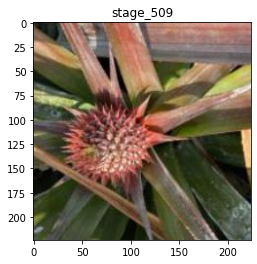

In [7]:
# Test dataloader
label_sets = {
    0 : 'stage_501',
    1 : 'stage_505',
    2 : 'stage_509',
    3 : 'stage_601',
    4 : 'stage_605',
    5 : 'stage_609',
    6 : 'stage_701',
    7 : 'stage_705',
    8 : 'stage_709'
}
img, label = next(iter(train_loader))
img = transforms.ToPILImage()(img[0]).convert('RGB')
plt.title(label_sets[int(label[0])])
plt.imshow(img)


## Training model

In [8]:
class Classifier(nn.Module):
  def __init__(self):
    super().__init__()
    self.cnn_layers = nn.Sequential(
        # Input shape[3, 224, 224]
        # TODO: CNN layers
        #nn.Conv2d(input, output, kernelsize, stride, padding)
        nn.Conv2d(3, 64, 3, 1, 1),#output shape(64, 224, 224 )
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(2, 2, 0),#output shape(64, 112, 112 )

        nn.Conv2d(64, 128, 3, 1, 1),#output shape(128, 112, 112 )
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.MaxPool2d(2, 2, 0),#output shape(128, 56, 56 )

        nn.Conv2d(128, 256, 3, 1, 1),#output shape(256, 56 56 )
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.MaxPool2d(4, 4, 0),#output shape(256, 14, 14 )

        # nn.Conv2d(256, 512, 3, 1, 1),#output shape(128, 14, 14 )
        # nn.BatchNorm2d(512),
        # nn.ReLU(),
        # nn.MaxPool2d(2, 2, 0),#output shape(512, 7, 7 )

    )

    self.fc_layers = nn.Sequential(
        # TODO: Fully connected layer
        nn.Linear(256 * 14 * 14, 128),
        nn.ReLU(),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Linear(64, 32),
        nn.ReLU(),
        nn.Linear(32, 9)
    )
    
  def forward(self, x):
    x = self.cnn_layers(x)

    # The extracted feature map must be flatten before going to fully-connected layers.
    x = torch.flatten(x, 1)

    x = self.fc_layers(x)
    return x

## Training

In [9]:
# Set the random seed.
seed = 0
torch.manual_seed(seed)
if(torch.cuda.is_available()):
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

# "cuda" only when GPUs are available.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

# Initialize a model, and put it on the device specified.

# model = Classifier().to(device)
model = models.resnet18(pretrained=True)
model = model.to(device)
# For Resnet Finetunning

# model.fc.in_features
# model.fc = nn.Linear(224, len(label_sets))

# model.device = device



# For the classification task, we use cross-entropy as the measurement of performance.
criterion = nn.CrossEntropyLoss()

# Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.
optimizer = torch.optim.Adam(model.parameters(), lr=0.0002, weight_decay=1e-5)

# The number of training epochs.
epoch_num = 30

valid_acc = 0.0

# Store the accuracy history during training
train_acc_his = []
valid_acc_his = []
train_loss_his = []
valid_loss_his = []

for epoch in range(epoch_num):
  model.train()
  # These are used to record information in training.
  train_loss = []
  train_accs = []
  y_pred = []
  y_test = []

  for batch in tqdm(train_loader):

    imgs, labels = batch

    # Forward the data. (Make sure data and model are on the same device.)
    logits = model(imgs.to(device))

    # Calculate the cross-entropy loss.
    # We don't need to apply softmax before computing cross-entropy as it is done automatically.
    loss = criterion(logits, labels.to(device))

    # Gradients stored in the parameters in the previous step should be cleared out first.
    optimizer.zero_grad()

    # Compute the gradients for parameters.
    loss.backward()

    # Clip the gradient norms for stable training.
    grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)

    # Update the parameters with computed gradients.
    optimizer.step()

    # Compute the accuracy for current batch.
    acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

    # Record the loss and accuracy.
    train_loss.append(loss.item())
    train_accs.append(acc)

  # The average loss and accuracy of the training set is the average of the recorded values.
  train_loss = sum(train_loss) / len(train_loss)
  train_acc = sum(train_accs) / len(train_accs)

  # Print the information.
  print(f"[ Train | {epoch + 1:03d}/{epoch_num:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")
  train_acc_his.append(train_acc)
  train_loss_his.append(train_loss)

  # ---------- Validation ----------
  # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
  model.eval()

  # These are used to record information in validation.
  valid_loss = []
  valid_accs = []

  # Iterate the validation set by batches.
  for batch in tqdm(valid_loader):

      # A batch consists of image data and corresponding labels.
      imgs, labels = batch

      # We don't need gradient in validation.
      # Using torch.no_grad() accelerates the forward process.
      with torch.no_grad():
        logits = model(imgs.to(device))

      # We can still compute the loss (but not the gradient).
      loss = criterion(logits, labels.to(device))

      # Compute the accuracy for current batch.
      acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

      # Record the loss and accuracy.
      valid_loss.append(loss.item())
      valid_accs.append(acc)

      # record predict result
      _, preds = torch.max(logits, 1)
      y_pred.extend(preds.view(-1).detach().cpu().numpy())       # 將preds預測結果detach出來，並轉成numpy格式       
      y_test.extend(labels.view(-1).detach().cpu().numpy())      # target是ground-truth的label

  # The average loss and accuracy for entire validation set is the average of the recorded values.
  valid_loss = sum(valid_loss) / len(valid_loss)
  valid_acc = sum(valid_accs) / len(valid_accs)

  # Print the information.
  print(f"[ Valid | {epoch + 1:03d}/{epoch_num:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")
  valid_acc_his.append(valid_acc)
  valid_loss_his.append(valid_loss)


cuda


/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

  0%|          | 0/26 [00:00<?, ?it/s]

[ Train | 001/030 ] loss = 1.40057, acc = 0.75048


  0%|          | 0/3 [00:00<?, ?it/s]

[ Valid | 001/030 ] loss = 0.56950, acc = 0.79647


  0%|          | 0/26 [00:00<?, ?it/s]

[ Train | 002/030 ] loss = 0.09443, acc = 0.96983


  0%|          | 0/3 [00:00<?, ?it/s]

[ Valid | 002/030 ] loss = 0.11551, acc = 0.95593


  0%|          | 0/26 [00:00<?, ?it/s]

[ Train | 003/030 ] loss = 0.02454, acc = 0.99339


  0%|          | 0/3 [00:00<?, ?it/s]

[ Valid | 003/030 ] loss = 0.13246, acc = 0.96114


  0%|          | 0/26 [00:00<?, ?it/s]

[ Train | 004/030 ] loss = 0.00748, acc = 0.99940


  0%|          | 0/3 [00:00<?, ?it/s]

[ Valid | 004/030 ] loss = 0.11269, acc = 0.97155


  0%|          | 0/26 [00:00<?, ?it/s]

[ Train | 005/030 ] loss = 0.00387, acc = 1.00000


  0%|          | 0/3 [00:00<?, ?it/s]

[ Valid | 005/030 ] loss = 0.13185, acc = 0.95994


  0%|          | 0/26 [00:00<?, ?it/s]

[ Train | 006/030 ] loss = 0.00232, acc = 1.00000


  0%|          | 0/3 [00:00<?, ?it/s]

[ Valid | 006/030 ] loss = 0.11303, acc = 0.96635


  0%|          | 0/26 [00:00<?, ?it/s]

[ Train | 007/030 ] loss = 0.00101, acc = 1.00000


  0%|          | 0/3 [00:00<?, ?it/s]

[ Valid | 007/030 ] loss = 0.12511, acc = 0.96114


  0%|          | 0/26 [00:00<?, ?it/s]

[ Train | 008/030 ] loss = 0.00131, acc = 1.00000


  0%|          | 0/3 [00:00<?, ?it/s]

[ Valid | 008/030 ] loss = 0.14493, acc = 0.95072


  0%|          | 0/26 [00:00<?, ?it/s]

[ Train | 009/030 ] loss = 0.00121, acc = 1.00000


  0%|          | 0/3 [00:00<?, ?it/s]

[ Valid | 009/030 ] loss = 0.12103, acc = 0.96635


  0%|          | 0/26 [00:00<?, ?it/s]

[ Train | 010/030 ] loss = 0.00073, acc = 1.00000


  0%|          | 0/3 [00:00<?, ?it/s]

[ Valid | 010/030 ] loss = 0.11381, acc = 0.97155


  0%|          | 0/26 [00:00<?, ?it/s]

[ Train | 011/030 ] loss = 0.00045, acc = 1.00000


  0%|          | 0/3 [00:00<?, ?it/s]

[ Valid | 011/030 ] loss = 0.10995, acc = 0.96635


  0%|          | 0/26 [00:00<?, ?it/s]

[ Train | 012/030 ] loss = 0.00101, acc = 1.00000


  0%|          | 0/3 [00:00<?, ?it/s]

[ Valid | 012/030 ] loss = 0.11897, acc = 0.96635


  0%|          | 0/26 [00:00<?, ?it/s]

[ Train | 013/030 ] loss = 0.00425, acc = 0.99820


  0%|          | 0/3 [00:00<?, ?it/s]

[ Valid | 013/030 ] loss = 0.11334, acc = 0.96514


  0%|          | 0/26 [00:00<?, ?it/s]

[ Train | 014/030 ] loss = 0.00642, acc = 0.99820


  0%|          | 0/3 [00:00<?, ?it/s]

[ Valid | 014/030 ] loss = 0.10967, acc = 0.96635


  0%|          | 0/26 [00:00<?, ?it/s]

[ Train | 015/030 ] loss = 0.01000, acc = 0.99820


  0%|          | 0/3 [00:00<?, ?it/s]

[ Valid | 015/030 ] loss = 0.14606, acc = 0.96234


  0%|          | 0/26 [00:00<?, ?it/s]

[ Train | 016/030 ] loss = 0.01648, acc = 0.99579


  0%|          | 0/3 [00:00<?, ?it/s]

[ Valid | 016/030 ] loss = 0.21585, acc = 0.94431


  0%|          | 0/26 [00:00<?, ?it/s]

[ Train | 017/030 ] loss = 0.07652, acc = 0.97644


  0%|          | 0/3 [00:00<?, ?it/s]

[ Valid | 017/030 ] loss = 0.49655, acc = 0.91827


  0%|          | 0/26 [00:00<?, ?it/s]

[ Train | 018/030 ] loss = 0.09403, acc = 0.97464


  0%|          | 0/3 [00:00<?, ?it/s]

[ Valid | 018/030 ] loss = 0.33447, acc = 0.91026


  0%|          | 0/26 [00:00<?, ?it/s]

[ Train | 019/030 ] loss = 0.04484, acc = 0.98594


  0%|          | 0/3 [00:00<?, ?it/s]

[ Valid | 019/030 ] loss = 0.32833, acc = 0.93510


  0%|          | 0/26 [00:00<?, ?it/s]

[ Train | 020/030 ] loss = 0.04017, acc = 0.98858


  0%|          | 0/3 [00:00<?, ?it/s]

[ Valid | 020/030 ] loss = 0.21940, acc = 0.93910


  0%|          | 0/26 [00:00<?, ?it/s]

[ Train | 021/030 ] loss = 0.01292, acc = 0.99459


  0%|          | 0/3 [00:00<?, ?it/s]

[ Valid | 021/030 ] loss = 0.11881, acc = 0.96514


  0%|          | 0/26 [00:00<?, ?it/s]

[ Train | 022/030 ] loss = 0.01750, acc = 0.99627


  0%|          | 0/3 [00:00<?, ?it/s]

[ Valid | 022/030 ] loss = 0.13671, acc = 0.97676


  0%|          | 0/26 [00:00<?, ?it/s]

[ Train | 023/030 ] loss = 0.02769, acc = 0.99147


  0%|          | 0/3 [00:00<?, ?it/s]

[ Valid | 023/030 ] loss = 0.17080, acc = 0.96114


  0%|          | 0/26 [00:00<?, ?it/s]

[ Train | 024/030 ] loss = 0.01471, acc = 0.99579


  0%|          | 0/3 [00:00<?, ?it/s]

[ Valid | 024/030 ] loss = 0.17890, acc = 0.93790


  0%|          | 0/26 [00:00<?, ?it/s]

[ Train | 025/030 ] loss = 0.01433, acc = 0.99519


  0%|          | 0/3 [00:00<?, ?it/s]

[ Valid | 025/030 ] loss = 0.28651, acc = 0.90785


  0%|          | 0/26 [00:00<?, ?it/s]

[ Train | 026/030 ] loss = 0.00713, acc = 0.99820


  0%|          | 0/3 [00:00<?, ?it/s]

[ Valid | 026/030 ] loss = 0.19578, acc = 0.95994


  0%|          | 0/26 [00:00<?, ?it/s]

[ Train | 027/030 ] loss = 0.00178, acc = 1.00000


  0%|          | 0/3 [00:00<?, ?it/s]

[ Valid | 027/030 ] loss = 0.15040, acc = 0.96514


  0%|          | 0/26 [00:00<?, ?it/s]

[ Train | 028/030 ] loss = 0.00031, acc = 1.00000


  0%|          | 0/3 [00:00<?, ?it/s]

[ Valid | 028/030 ] loss = 0.16700, acc = 0.95994


  0%|          | 0/26 [00:00<?, ?it/s]

[ Train | 029/030 ] loss = 0.00234, acc = 1.00000


  0%|          | 0/3 [00:00<?, ?it/s]

[ Valid | 029/030 ] loss = 0.16642, acc = 0.95994


  0%|          | 0/26 [00:00<?, ?it/s]

[ Train | 030/030 ] loss = 0.00196, acc = 0.99940


  0%|          | 0/3 [00:00<?, ?it/s]

[ Valid | 030/030 ] loss = 0.15046, acc = 0.95994


In [10]:
# Save the model
torch.save(model, "mymodel.pth")


## Plot learning history

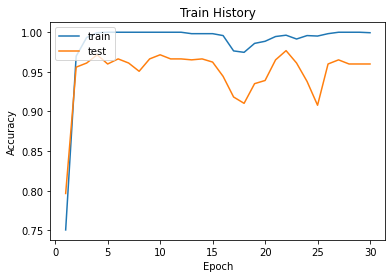

AttributeError: ignored

In [11]:
def show_train_history(train_acc,valid_acc,ylabel):
    epoch = np.linspace(1,30,30)
    for i in range(len(train_acc)):
      train_acc[i] = train_acc[i].detach().to('cpu').numpy()
    for i in range(len(valid_acc)):
      valid_acc[i] = valid_acc[i].detach().to('cpu').numpy()

    plt.plot(epoch, train_acc)
    plt.plot(epoch, valid_acc)
    plt.title('Train History')
    plt.ylabel(ylabel)
    plt.xlabel('Epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

show_train_history(train_acc_his,valid_acc_his,'Accuracy')
show_train_history(train_loss_his,valid_loss_his,'Loss')


### Confusion map

In [12]:
# util functions
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        # print("Normalized confusion matrix")
    else:
      pass
        # print('Confusion matrix, without normalization')

    # print(cm)
    plt.figure(figsize=(6, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    # plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

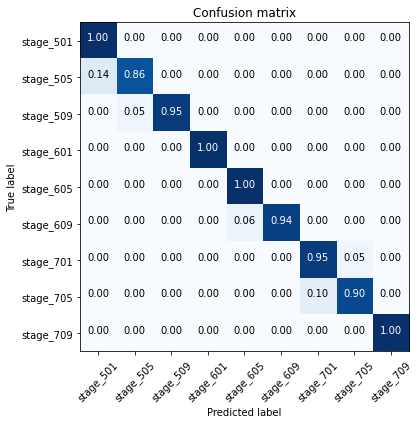

In [ ]:
from sklearn.metrics import confusion_matrix
import time
import itertools

classes = ['stage_501',
    'stage_505',
    'stage_509',
    'stage_601',
    'stage_605',
    'stage_609',
    'stage_701',
    'stage_705',
    'stage_709']
matrix = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(matrix, classes=classes, normalize=True)

# Explanable AI

tensor([5, 5, 2, 3, 8, 4, 6, 6, 4, 5])


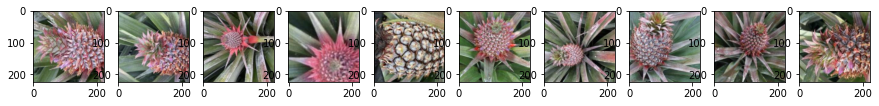

In [13]:
# The images for observation
XAI_loader = DataLoader(valid_set, batch_size=10, shuffle=True)
# images = []
# labels = np.arange(0, 9)
# images = torch.empty((3, 224, 224))
# labels = torch.tensor(labels)
# print(labels)
# label_count = 0
# while len(images) < 9:
#   image_set, label_set = next(iter(XAI_loader))
#   print(image_set.shape)
#   for i in range(len(label_set)):
#     print(i)
#     if label_set[i] == label_count:
#       label_count = label_count + 1
#       images = torch.cat((images, image_set[i]), 1)
# print(images.shape)
# images = torch.tensor(images)
# labels = torch.tensor(labels)
images, labels = next(iter(XAI_loader))
fig, axs = plt.subplots(1, len(images), figsize=(15, 8))
print(labels)
for i, img in enumerate(images):
  axs[i].imshow(img.cpu().permute(1, 2, 0))
  # axs[i].set_title(label_sets[int(labels[i])])

### Lime
https://github.com/marcotcr/lime/blob/master/doc/notebooks/Tutorial%20-%20images%20-%20Pytorch.ipynb

In [ ]:
# install lime in colab
!pip install lime==0.1.1.37

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


TypeError: ignored

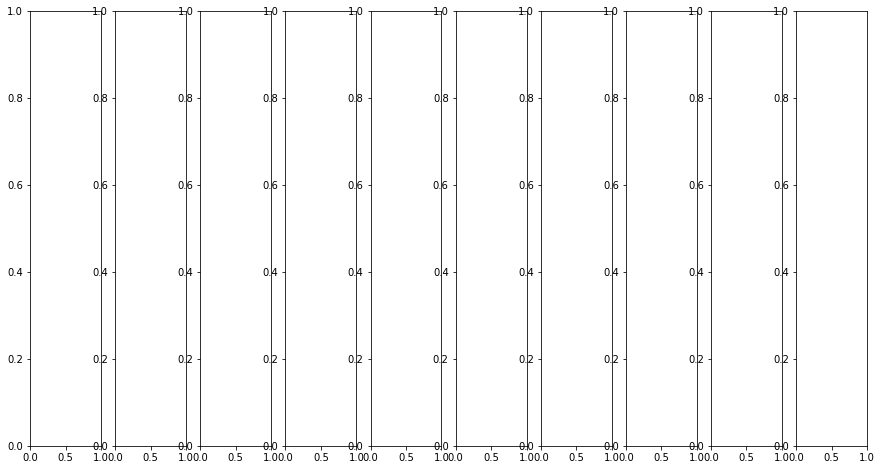

In [ ]:
from lime import lime_image
from skimage.segmentation import slic
def predict(input):
    # input: numpy array, (batches, height, width, channels)                                                                                                                                                     
    
    model.eval()                                                                                                                                                             
    input = torch.FloatTensor(input).permute(0, 3, 1, 2)                                                                                                            
    # pytorch tensor, (batches, channels, height, width)

    output = model(input.cuda())                                                                                                                                             
    return output.detach().cpu().numpy()                                                                                                                              
                                                                                                                                                                             
def segmentation(input):
    # split the image into 200 pieces with the help of segmentaion from skimage                                                                                                                   
    return slic(input, n_segments=200, compactness=1, sigma=1)                                                                                                              
                                                                                                                                                                             

fig, axs = plt.subplots(1, len(images), figsize=(15, 8))                                                                                                                                                                 
# fix the random seed to make it reproducible
np.random.seed(16)                                                                                                                                                       
for idx, (image, label) in enumerate(zip(images.permute(0, 2, 3, 1).numpy(), labels)):                                                                                                                                             
    x = image.astype(np.double)
    # numpy array for lime

    explainer = lime_image.LimeImageExplainer()                                                                                                                              
    explaination = explainer.explain_instance(image=x, classifier_fn=predict, segmentation_fn=segmentation)

    # doc: https://lime-ml.readthedocs.io/en/latest/lime.html?highlight=explain_instance#lime.lime_image.LimeImageExplainer.explain_instance

    lime_img, mask = explaination.get_image_and_mask(                                                                                                                         
                                label=label.item(),                                                                                                                           
                                positive_only=False,                                                                                                                         
                                hide_rest=False,                                                                                                                             
                                num_features=9,                                                                                                                              
                                min_weight=0.05                                                                                                                              
                            )
    # turn the result from explainer to the image
    # doc: https://lime-ml.readthedocs.io/en/latest/lime.html?highlight=get_image_and_mask#lime.lime_image.ImageExplanation.get_image_and_mask
    axs[idx].imshow(lime_img)

plt.show()
plt.close()

### Draw saliency map

In [ ]:
def normalize(image):
  return (image - image.min()) / (image.max() - image.min())
  # return torch.log(image)/torch.log(image.max())

def compute_saliency_maps(x, y, model):
  model.eval()
  x = x.cuda()

  # we want the gradient of the input x
  x.requires_grad_()
  
  y_pred = model(x)
  loss_func = torch.nn.CrossEntropyLoss()
  loss = loss_func(y_pred, y.cuda())
  loss.backward()

  # saliencies = x.grad.abs().detach().cpu()
  saliencies, _ = torch.max(x.grad.data.abs().detach().cpu(),dim=1)

  # We need to normalize each image, because their gradients might vary in scale, but we only care about the relation in each image
  saliencies = torch.stack([normalize(item) for item in saliencies])
  return saliencies

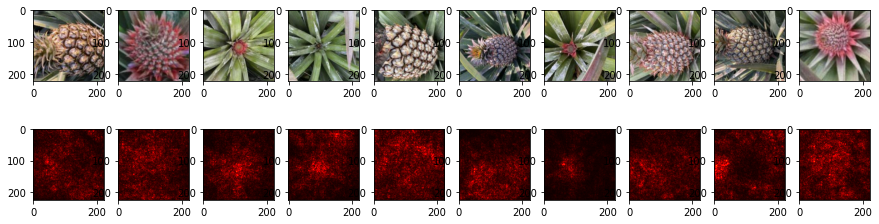

In [ ]:
# images, labels = train_set.getbatch(img_indices)
saliencies = compute_saliency_maps(images, labels, model)

# visualize
fig, axs = plt.subplots(2, len(images), figsize=(15, 4))
for row, target in enumerate([images, saliencies]):
  for column, img in enumerate(target):
    if row==0:
      axs[row][column].imshow(img.permute(1, 2, 0).numpy())
      # What is permute?
      # In pytorch, the meaning of each dimension of image tensor is (channels, height, width)
      # In matplotlib, the meaning of each dimension of image tensor is (height, width, channels)
      # permute is a tool for permuting dimensions of tensors
      # For example, img.permute(1, 2, 0) means that,
      # - 0 dimension is the 1 dimension of the original tensor, which is height
      # - 1 dimension is the 2 dimension of the original tensor, which is width
      # - 2 dimension is the 0 dimension of the original tensor, which is channels
    else:
      axs[row][column].imshow(img.numpy(), cmap=plt.cm.hot)
    
plt.show()
plt.close()

### Integrated Gradient

In [ ]:
class IntegratedGradients():
    def __init__(self, model):
        self.model = model
        self.gradients = None
        # Put model in evaluation mode
        self.model.eval()

    def generate_images_on_linear_path(self, input_image, steps):
        # Generate scaled xbar images
        xbar_list = [input_image*step/steps for step in range(steps)]
        return xbar_list

    def generate_gradients(self, input_image, target_class):
        # We want to get the gradients of the input image
        input_image.requires_grad=True
        # Forward
        model_output = self.model(input_image)
        # Zero grads
        self.model.zero_grad()
        # Target for backprop
        one_hot_output = torch.FloatTensor(1, model_output.size()[-1]).zero_().cuda()
        one_hot_output[0][target_class] = 1
        # Backward
        model_output.backward(gradient=one_hot_output)
        self.gradients = input_image.grad
        # Convert Pytorch variable to numpy array
        # [0] to get rid of the first channel (1,3,128,128)
        gradients_as_arr = self.gradients.data.cpu().numpy()[0]
        return gradients_as_arr

    def generate_integrated_gradients(self, input_image, target_class, steps):
        # Generate xbar images
        xbar_list = self.generate_images_on_linear_path(input_image, steps)
        # Initialize an iamge composed of zeros
        integrated_grads = np.zeros(input_image.size())
        for xbar_image in xbar_list:
            # Generate gradients from xbar images
            single_integrated_grad = self.generate_gradients(xbar_image, target_class)
            # Add rescaled grads from xbar images
            integrated_grads = integrated_grads + single_integrated_grad/steps
        # [0] to get rid of the first channel (1,3,128,128)
        return integrated_grads[0]

def normalize(image):
  return (image - image.min()) / (image.max() - image.min())

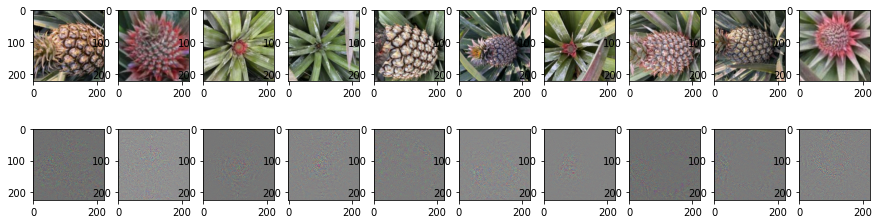

In [ ]:
# put the image to cuda
images = images.cuda()

IG = IntegratedGradients(model)
integrated_grads = []
for i, img in enumerate(images):
  img = img.unsqueeze(0)
  integrated_grads.append(IG.generate_integrated_gradients(img, labels[i], 1000))
fig, axs = plt.subplots(2, len(images), figsize=(15, 4))
for i, img in enumerate(images):
  axs[0][i].imshow(img.cpu().permute(1, 2, 0))
for i, img in enumerate(integrated_grads):
  axs[1][i].imshow(np.moveaxis(normalize(img),0,-1))
plt.show()
plt.close()